**IMPORTANT** <br> <ul> <li> Do **NOT** replace or remove this notebook (ipynb file)! Each cell has unique nbgrader's metadata and ID which, if changed outside the nbgrader, cannot pass the tests. Do **NOT** change the name of the file!</li> <li> To receive any credit, don't forget to **SUBMIT** your notebook when you are done! You can have multiple submissions before the deadline; only the last one is saved, including its timestamp.</li> <li>Before submitting, **Validate** your notebook to check if your codes pass all visible tests. </li> <li>Make sure you fill in any cell with the comment `# your code here`. Remove or comment the command `fail()` (in R), or `raise NotImplementedError` (in Python) and place your code there </li> </ul>

In [ ]:
NAME = "Christian Olivares-Rodriguez"

---

# Homework #1: Gathering and Transforming Data, Plus Basic Models

In this homework we go through the following:

1. Some data gathering and merging tasks often needed to get all our data in one place
2. Some minimal geospatial data visualization
3. Do a stratified test-train split
4. Make some data processing pipelines: Impute missing data, rescale continuous variables, and encode categorical variables
5. Train some candidate models and evaluate using cross-validation
6. Test on testing data

### More specifically:

Our goal will be to predict county-level public and domestic self-supply water withdrawals from the basic characteristics/demographics of each county. Note that we are not considering irrigation water or thermoelectric withdrawals, which are the dominant water uses in this country. Our main steps follow:

#### 1. Load and merge into one the following datasets:

1. County GeoDataFrame
2. Census Division Codes
3. 2015 average temperature and precipitation for each county
4. USGS water withdrawal data for 2015
5. County population and income data from the US Bureau of Economic Analysis

#### 2. Make a test/train split stratified by Census Division

#### 3. Do imputation and rescaling in pipelines

#### 4. Train candidate models, test on testing data


In [2]:
#Load the libraries: Run this cell first!

#Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

#Stuff we'll need from scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## 1. Load and Plot County Shapefiles for the Contiguous US {-}

For your first task, simply run the following cells to download Census shapefiles as a GeoDataFrame for:

- All US counties into a `GeoDataFrame`.
- All US states into a `GeoDataFrame`.

1. The links for high resolution shapefiles are 

- https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2021_us_county_500k.zip
- https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip

2. We will exclude every row that does not represent one of the lower 48 states or the District of Columbia, as encoded by the variabel `STATEFP`.  The state FP codes that we filter out are:

- Hawaii = 15
- Alaska = 02
- Puerto Rico = 72
- Guam = 66
- Northern Mariana Islands = 69
- American Samoa = 60
- Virgin Islands = 78

3. Additionally, we convert the CRS from the default geographic CRS to something nicer for display: the North American Albers projection, with EPSG code 5070.


4. Finally, we make a simple plot of the states and counties to confirm that everthing went correctly. The plot should look like the following.

<img src="basic_geometries.png" alt="Basic geos" style="width:450px;"/>

### Assign the county geometry to the variable  `gdf`

**We will use this (`gdf`) as our main (Geo)DataFrame for the rest of the assignment**

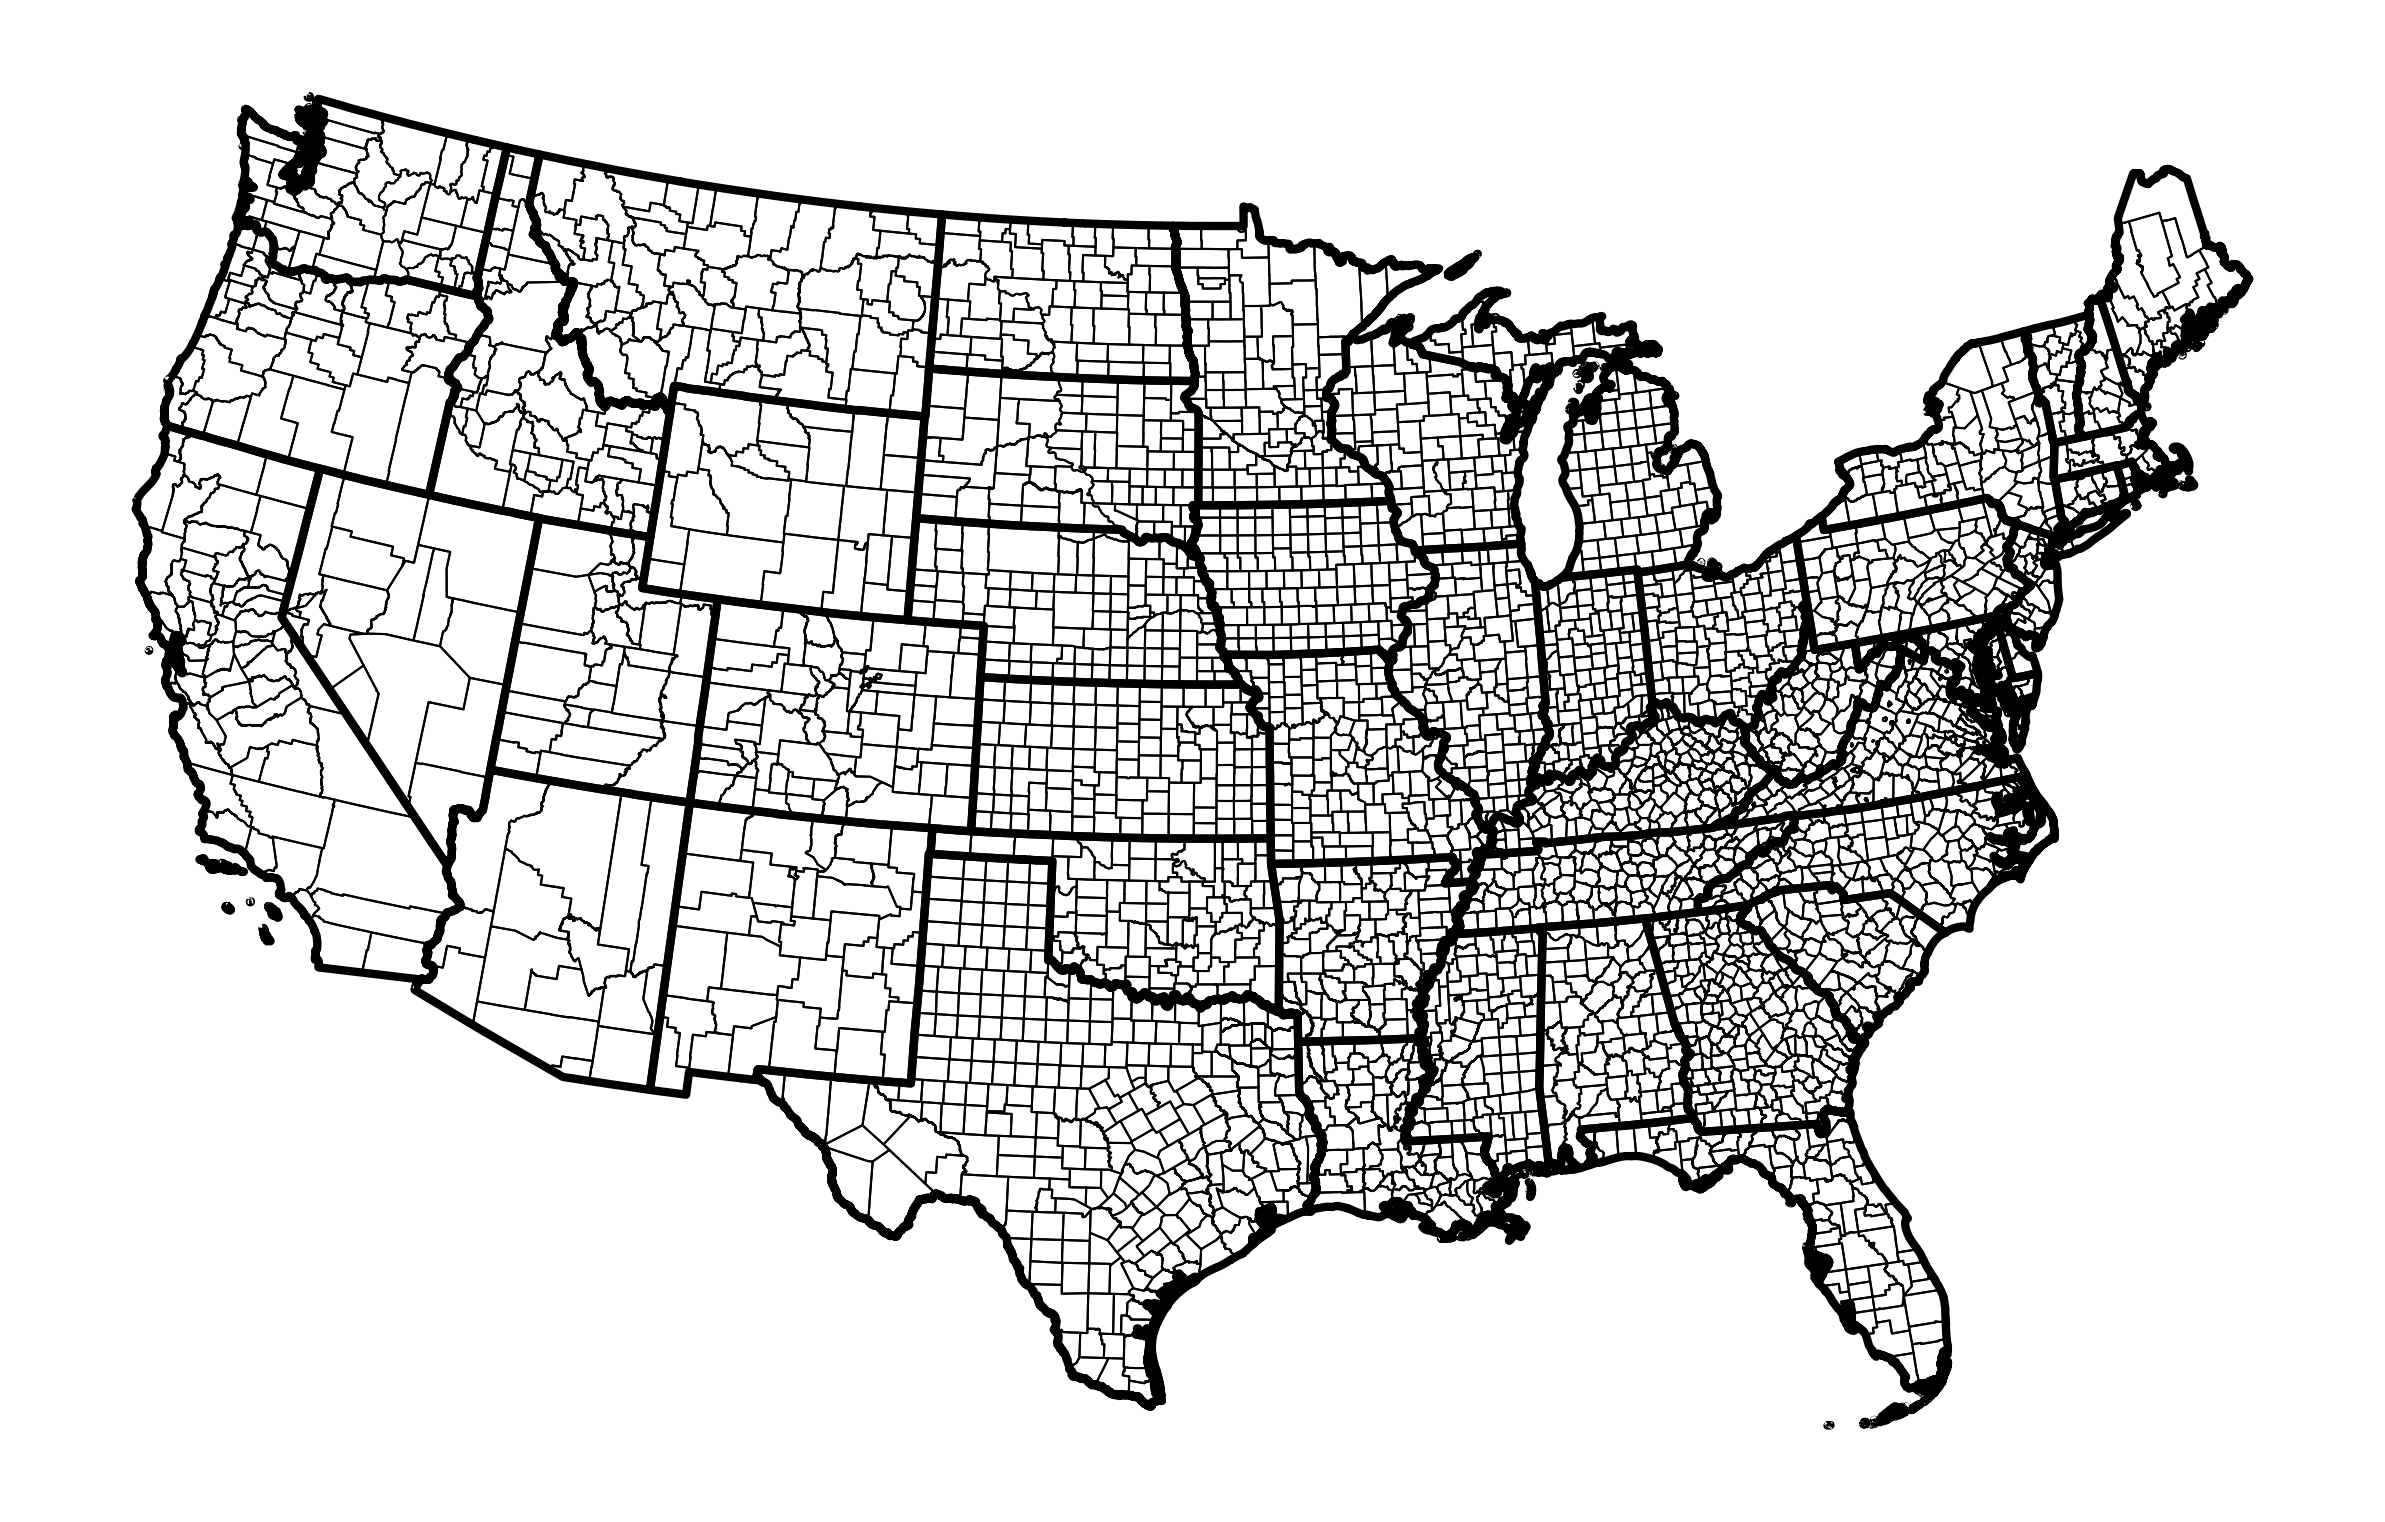

In [3]:

#Get shapefile data directly from census URLs:
#########

#Load the counties
url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip'
url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'
county_gdf = gpd.read_file(url_county)
state_gdf = gpd.read_file(url_state)

#Exclude everthing outside the contiguous US:
exclude_list = [15, 72, 2, 60, 66, 69, 78]
county_gdf = county_gdf.loc[~county_gdf['STATEFP'].astype(int).isin(exclude_list)]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]

########

#Convert to a prettier CRS:
###
county_gdf = county_gdf.to_crs(5070)
state_gdf = state_gdf.to_crs(5070)


#Plot:
###
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), dpi=300)

county_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')
state_gdf.plot(ax = ax1, linewidth = 2, edgecolor = 'black', facecolor='none')

ax1.set_axis_off()


######

## Get gdf as county_gdf
## This is our working GeoDataFrame; State geodataframe is just for background:

gdf = county_gdf



## 2. Merge in the Census Division Codes

- Use the file `state-geocodes.csv` to get codes for the Census Division for each state
- Merge the Division code into the county GeoDataFrame, `gdf`: You will need to use the STATE FIPS code as your key (the variable names differ between files). *Use a **left join**.*
- The new column should be named `Division`
- Confirm you did it correctly, by plotting your county GeoDataFrame by `column = Division`
- Your map should look something like the following:

<img src="division_map.png" alt="Division Map" style="width:500px;"/>

In [4]:
state_geocodes = pd.read_csv('state-geocodes.csv', header=5)

gdf['STATEFP'] = gdf['STATEFP'].astype(str).str.zfill(2)
state_geocodes['State (FIPS)'] = state_geocodes['State (FIPS)'].astype(str).str.zfill(2)

gdf = gdf.merge(state_geocodes[['State (FIPS)', 'Division']], left_on = 'STATEFP', right_on = 'State (FIPS)', how ='left')
print(gdf['Division'].iloc[:10])

0    4
1    4
2    8
3    8
4    3
5    4
6    8
7    2
8    7
9    7
Name: Division, dtype: int64


In [5]:
## test whether the first 10 values of column Division are correct
assert sum(gdf['Division'].iloc[:10] != [4, 4, 8, 8, 3, 4, 8, 2, 7, 7]) == 0

## 3. Add in County Temperature and Precipitation from NOAA "Climate at a Glance"

- We can get some county-level climate data from NOAA, at the following link:

https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/county/mapping/


Already provided are the 12-month average **temperature** and **precipitation** for each county in the Contiguous US for 2015 (starting in the month of January).  Note that it was necessary to manually fix line 1188 for Washington, D.C. (already done for you)

The following code use the csv files:

1. `county_temp_2015.csv`
2. `county_precip_2015.csv`

And does the following:

1. Loads these csv files into `temp_df` and `precip_df`.
2. Extracts the county FIPS code as a three-digit string.
3. Uses `us-state-ansi-fips.csv` to get a two-digit state FIPS code.
4. Creates a five digit string `FIPS` code that uniquely identifies each county in `temp_df`, `precip_df`, and `gdf`.


In [6]:
#Read the temperature/precipitation data:
temp_df = pd.read_csv('county_temp_2015.csv', header=4)
precip_df = pd.read_csv('county_precip_2015.csv', header=4)


#Get the county ID number:
temp_df['COUNTYFP'] = temp_df.ID.str[3:]

precip_df['COUNTYFP'] = temp_df.ID.str[3:]


## Map from the state name to statefp code:
ansi_df = pd.read_csv('us-state-ansi-fips.csv', dtype={'STATEFP':str})
ansi_df.STATEFP = ansi_df.STATEFP.str.zfill(2)


#Merge the state code:
temp_df = temp_df.merge(ansi_df[['stname', 'STATEFP']], left_on='State', right_on='stname', how='left')
precip_df = precip_df.merge(ansi_df[['stname', 'STATEFP']], left_on='State', right_on='stname', how='left')


#Add FIPS codes to everything:
temp_df['FIPS'] = temp_df['STATEFP'] + temp_df['COUNTYFP']
precip_df['FIPS'] = precip_df['STATEFP'] + precip_df['COUNTYFP']
gdf['FIPS'] = gdf['STATEFP'] + gdf['COUNTYFP']

### 3. Merge the DataFrames:

Now, do the following:

1. Name the temperature and precipitation columns `Temp` and `Precip`.

2. Using `FIPS` as your key, merge the temperature and precipitation columns into your county GeoDataFrame `gdf`. Use only **left joins**.

It is not required, but if you'd like, you can plot temperature and precipitation. You should get something like the following:

<img src="temp_precip_maps.png" alt="Basic geos" style="width:775px;"/>

In [7]:
# your code here
gdf['FIPS'] = gdf['FIPS'].astype(str)
temp_df['FIPS'] = temp_df['FIPS'].astype(str)
precip_df['FIPS'] = precip_df['FIPS'].astype(str)

temp_df.rename(columns = {'Value': 'Temp'}, inplace = True)
precip_df.rename(columns = {'Value': 'Precip'}, inplace = True)

gdf = gdf.merge(temp_df[['FIPS', 'Temp']], on = 'FIPS', how = 'left')

gdf = gdf.merge(precip_df[['FIPS', 'Precip']], on = 'FIPS', how = 'left')

In [8]:
## test whether the first 5 values of column Temp are correct
assert np.linalg.norm(np.array(gdf['Temp'].iloc[:5]) - np.array([53.1, 48.5, 42.1, 42.3, 43.1]), ord=2) < 1.e-5

## test whether the first 5 values of column Precip are correct
assert np.linalg.norm(np.array(gdf['Precip'].iloc[:5]) - np.array([28.91, 43.25, 20.83, 27.25, 36.36]), ord=2) < 1.e-5


## 4. Merge in USGS Water Withdrawal Data

County-level data on water withdrawals is available from the USGS at:

- <https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8>

Our file of interest (and included with this assignment):

- `usco2015v2.0.csv`: This file gives us county-level water use for a variety of ends.

We will only work with the columns `PS-Wtotl` and `DO-WFrTo`

Do the following:

1. Using the county FIPS code, merge `PS-Wtotl` and `DO-WFrTo` into your county GeoDataFrame.
2. Make a new column, `Water`, that is the sum of these two.
3. **Drop** any counties where `Water` is not greater than $0$.
4. Make a new column equal to the *natural* logarithm of `Water`; call it `log_Water`


Optionally, you can check your work by making a map of `log_Water`. It should resemble the following:

<img src="log_Water_map.png" alt="log Water" style="width:700px;"/>

In [9]:
# your code here
water_df = pd.read_csv('usco2015v2.0.csv', header = 1)

gdf['FIPS'] = gdf['FIPS'].astype(str).str.zfill(5)
water_df['FIPS'] = water_df['FIPS'].astype(str).str.zfill(5)

gdf = gdf.merge(water_df[['FIPS', 'PS-Wtotl', 'DO-WFrTo']], on = 'FIPS', how = 'left')

gdf['Water'] = gdf['PS-Wtotl'] + gdf['DO-WFrTo']

gdf = gdf[gdf['Water'] > 0]

gdf['log_Water'] = np.log(gdf['Water'])

In [10]:
## test whether the first 5 values of column Water are correct
assert np.linalg.norm(np.array(gdf['Water'].iloc[:5]) - np.array([3.21, 0.15, 2.21, 0.38, 0.73]), ord=2) < 1.e-5

## test whether the first 5 values of column log_Water are correct
assert np.linalg.norm(np.array(gdf['log_Water'].iloc[:5]) - np.array([1.166271, -1.897120, 0.792993, -0.967584, -0.314711]), ord=2) < 1.e-5


## 5. Get County Demographic and Income Information

Finally, let's load in some data on population and income from the US Bureau of Economic Analysis (for the year 2015)

- The data is contained in `BEA_2015.csv`

- Our data consists of three variables: (1) total personal income, (2) population, and (3) per capita personal income

- The data comes in long format, we'll need to pivot wide to merge to our map

Run the following cells to load the data, modify the `GeoFips` columns, rename the columns, pivot wide, and merge to `gdf`.

IMPORTANT: Your `gdf` must have a column named `FIPS` that is a five digit *string* code that identifies each county for the following to work.

In [11]:
#Get the data, read GeoFips as a string, plus header=3
bea_df = pd.read_csv('BEA_2015.csv', dtype={'GeoFips':str}, header=3)

#Buffer to have 5 digits
bea_df.GeoFips = bea_df.GeoFips.str.zfill(5)

#Check the result
bea_df.head()

,GeoFips,GeoName,LineCode,Description,2015
0,01001,"Autauga, AL",1,Personal income (thousands of dollars),2156845
1,01001,"Autauga, AL",2,Population (persons) 1/,56278
2,01001,"Autauga, AL",3,Per capita personal income (dollars) 2/,38325
3,01003,"Baldwin, AL",1,Personal income (thousands of dollars),8634950
4,01003,"Baldwin, AL",2,Population (persons) 1/,204925


In [12]:
##Pivot bea_df wide:
bea_df_pivot = bea_df.pivot(index=['GeoFips'], columns='Description', values=['2015'])

#Our intermediate result
display(bea_df_pivot.head())

#Clean up the column index:
bea_df_pivot.columns = bea_df_pivot.columns.droplevel()

#Get GeoFips back as a column
bea_df_pivot = bea_df_pivot.reset_index()

#And our final result:
bea_df_pivot.head()

2015  \
Description Per capita personal income (dollars) 2/   
GeoFips                                               
01001                                         38325   
01003                                         42137   
01005                                         31277   
01007                                         28886   
01009                                         32670   

                                                                            
Description Personal income (thousands of dollars) Population (persons) 1/  
GeoFips                                                                     
01001                                      2156845                   56278  
01003                                      8634950                  204925  
01005                                       833012                   26633  
01007                                       653018                   22607  
01009                                      1900332                   58168

Description,GeoFips,Per capita personal income (dollars) 2/,Personal income (thousands of dollars),Population (persons) 1/
0,01001,38325,2156845,56278
1,01003,42137,8634950,204925
2,01005,31277,833012,26633
3,01007,28886,653018,22607
4,01009,32670,1900332,58168


In [13]:
#Rename the columns
bea_df_pivot = bea_df_pivot.rename(columns={'Per capita personal income (dollars) 2/':'Per_cap_income',
                             'Personal income (thousands of dollars)':'Income',
                             'Population (persons) 1/':'Population'})

display(bea_df_pivot.head())

#Also note the datatypes: objects for all; we'll need to convert some to numeric
bea_df_pivot.dtypes

Description,GeoFips,Per_cap_income,Income,Population
0,01001,38325,2156845,56278
1,01003,42137,8634950,204925
2,01005,31277,833012,26633
3,01007,28886,653018,22607
4,01009,32670,1900332,58168


Description
GeoFips           object
Per_cap_income    object
Income            object
Population        object
dtype: object

In [14]:
#Convert to numeric: Only convert if we have a digit;
bea_df_pivot['Per_cap_income'] = bea_df_pivot['Per_cap_income'].apply(lambda x: pd.to_numeric(x) if x.isdigit() else np.nan)
bea_df_pivot['Income'] = bea_df_pivot['Income'].apply(lambda x: pd.to_numeric(x) if x.isdigit() else np.nan)
bea_df_pivot['Population'] = bea_df_pivot['Population'].apply(lambda x: pd.to_numeric(x) if x.isdigit() else np.nan)

#Confirm conversion
bea_df_pivot.dtypes

Description
GeoFips            object
Per_cap_income    float64
Income            float64
Population        float64
dtype: object

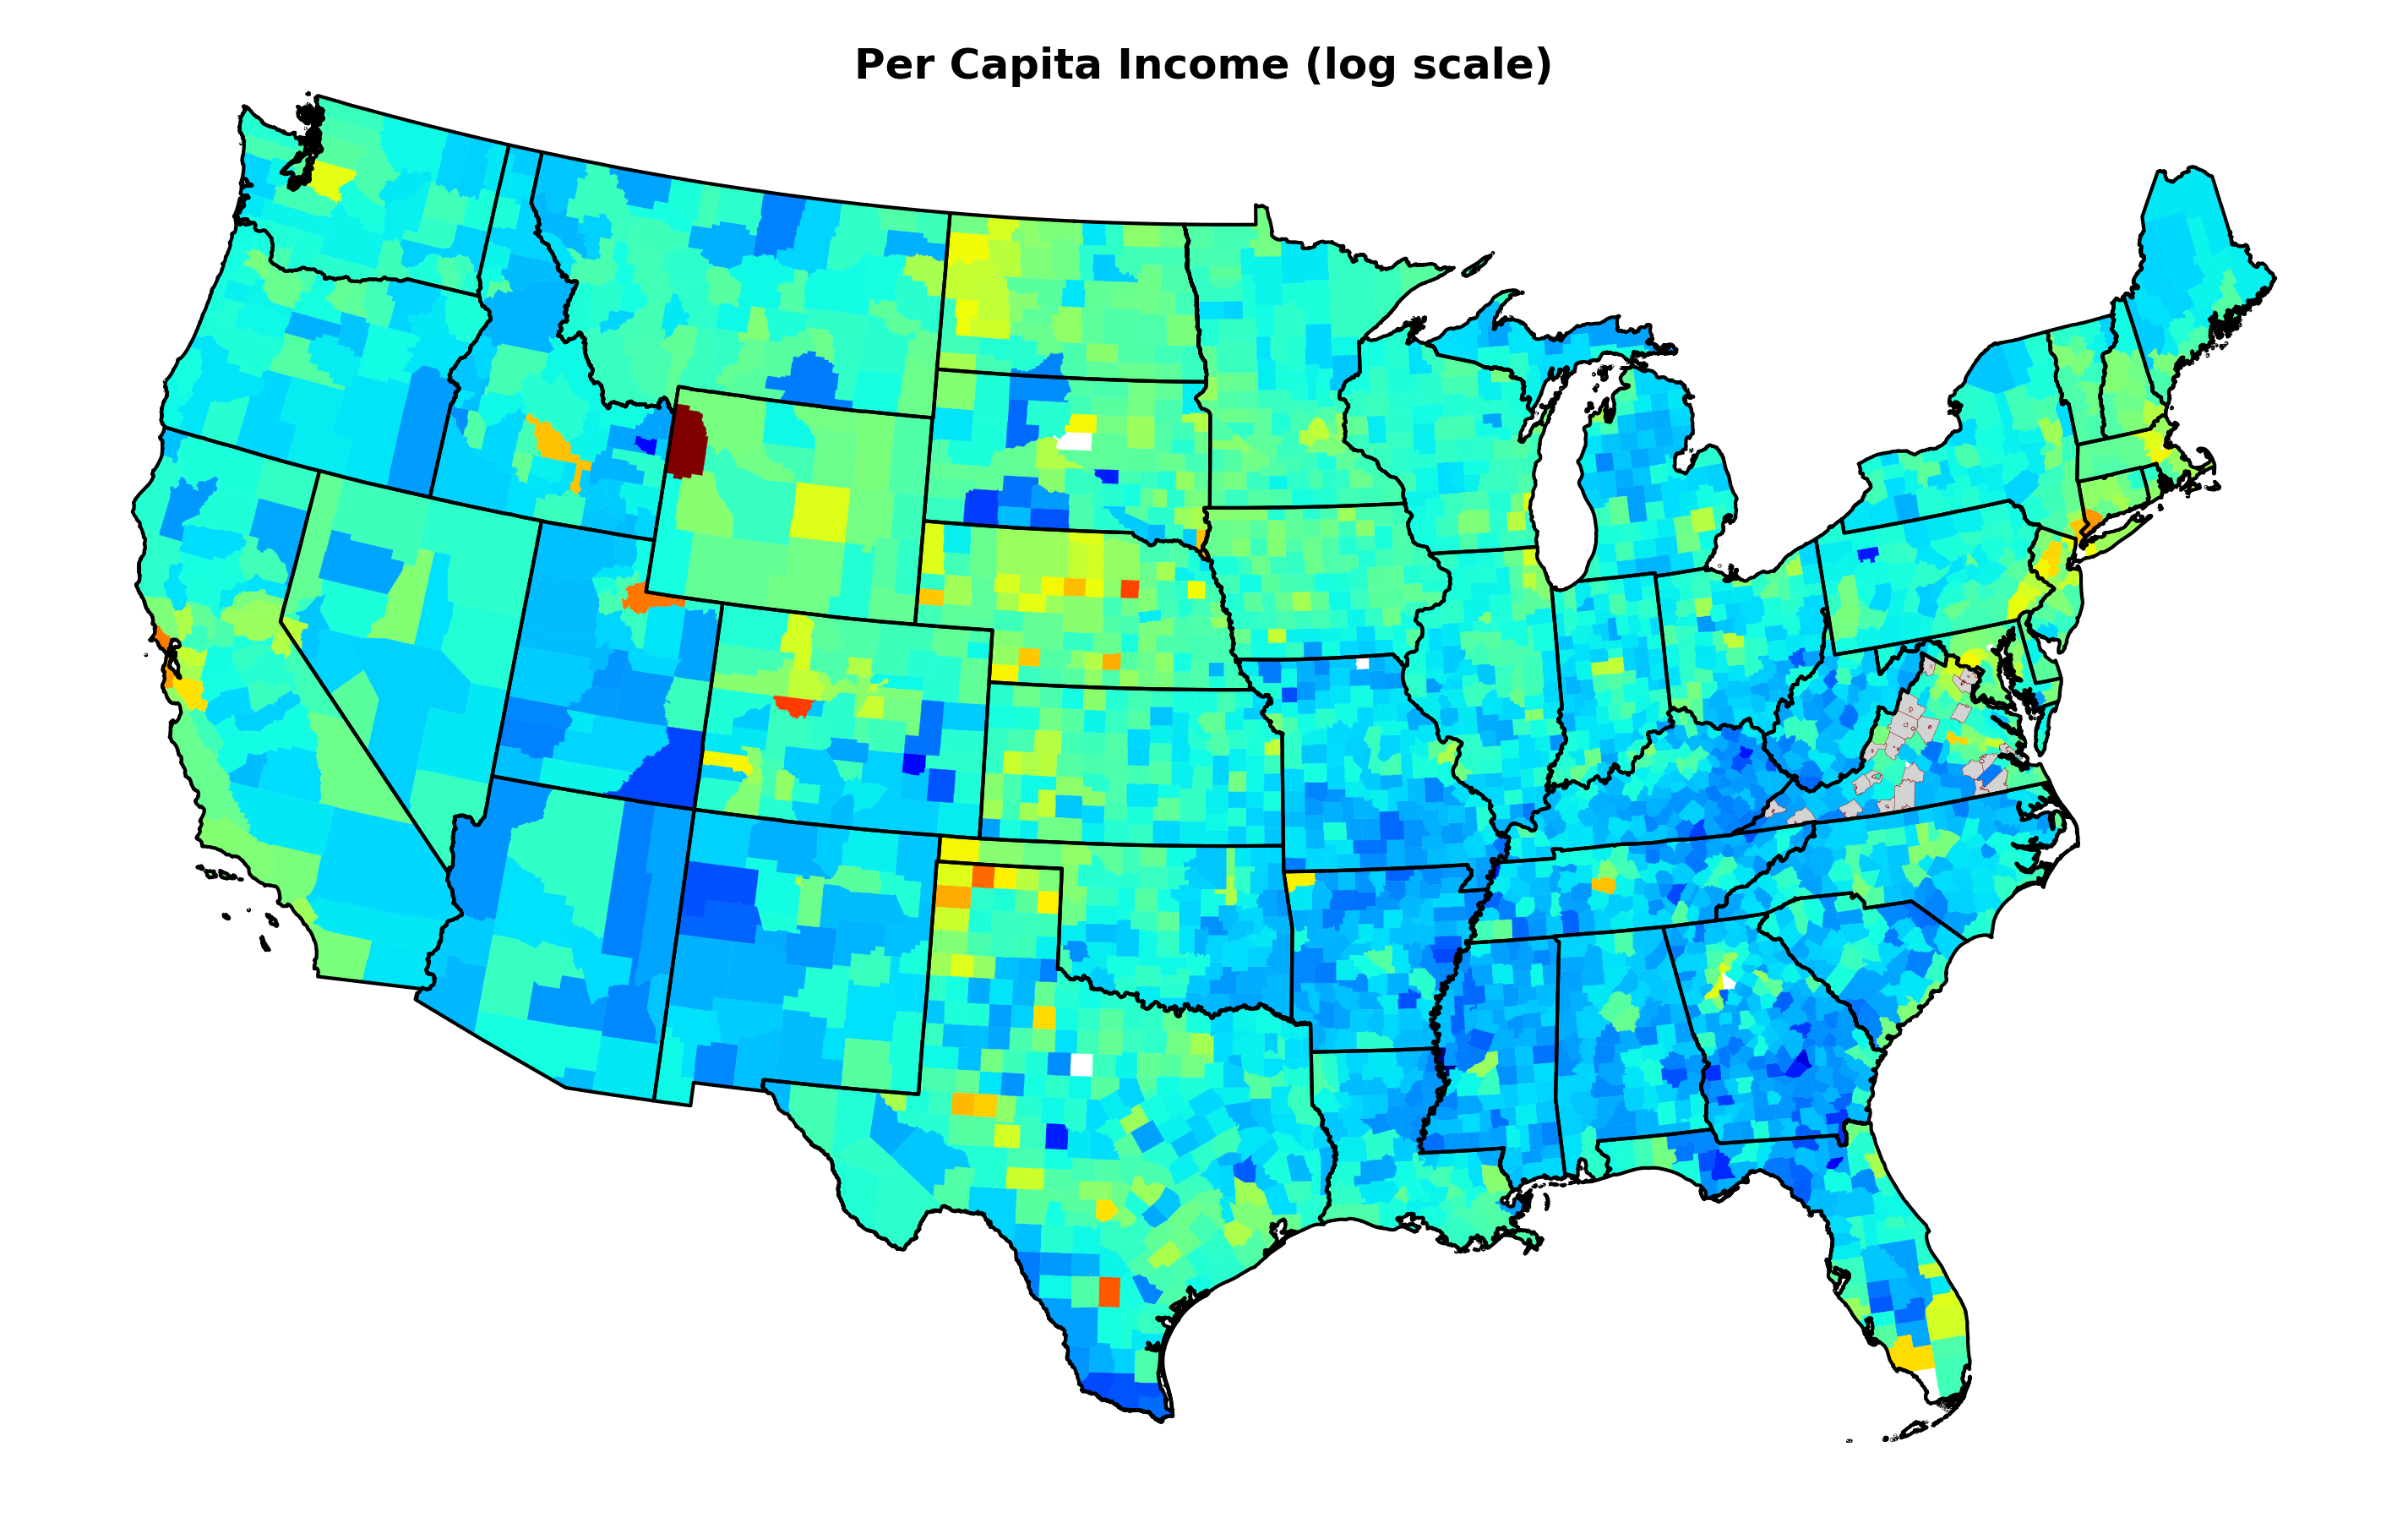

In [15]:
#Finally, let's merge, and do a quick plot to make sure it looks right
#Remember, gdf needs to have a FIPS column for this to work!
#####

gdf = gdf.merge(bea_df_pivot, left_on='FIPS', right_on = 'GeoFips', how='left')

#Plot on a log scale:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
gdf.plot(column=np.log(gdf['Per_cap_income']), edgecolor='face', linewidth=.1, cmap='jet', ax=ax1,
         missing_kwds={"color": "lightgrey", "edgecolor": "darkred", "hatch": "", "label": "Missing values"})
state_gdf.plot(facecolor='none', edgecolor='black', linewidth=1, ax=ax1)

ax1.set_axis_off()
ax1.set_title('Per Capita Income (log scale)', y=.95, fontweight='bold');

## 6. Distributions

Let's take a quick look at the distributions of some of the variables we have created.

- Plot histograms of the following variables (this should just take a line or two):

`Division`, `Temp`, `Precip`, `Income`, `Population`, `Per_cap_income`, `ALAND`, `Water`, `log_Water`

**For the rest of the homework, `log_Water` will be our output and the other columns (except `Water`) our predictors.**

It looks like we should log-transform several of these variables, but we'll get to that after the test-train split.

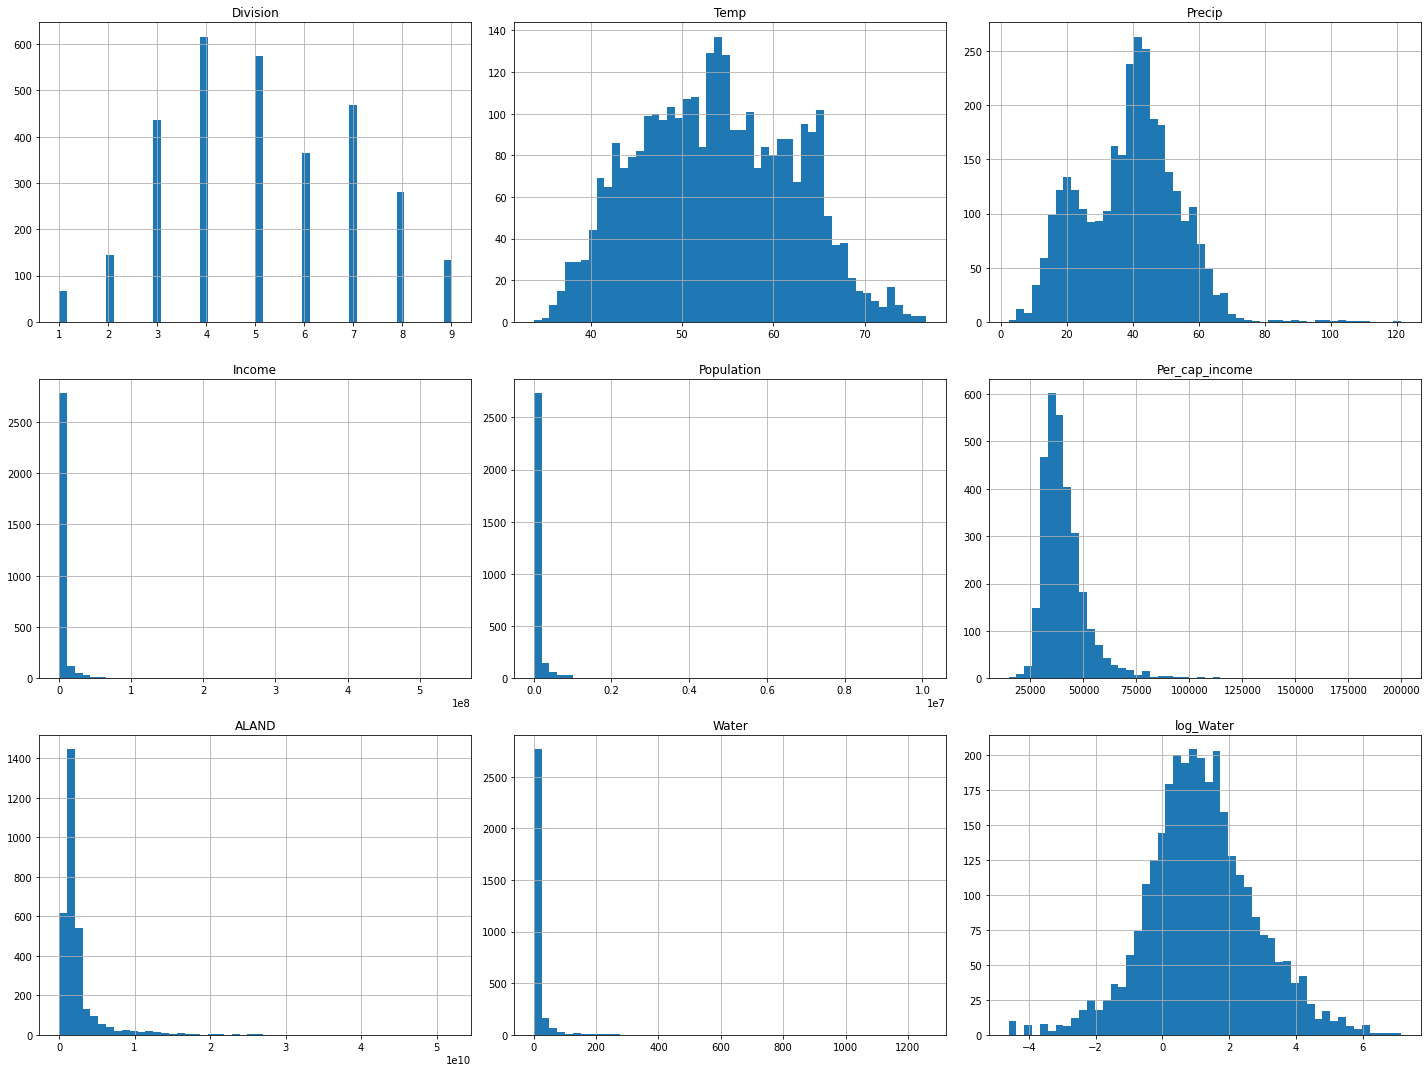

In [16]:
# your code here
gdf[['Division', 'Temp', 'Precip', 'Income', 'Population', 'Per_cap_income', 'ALAND', 'Water', 'log_Water']].hist(bins = 50, figsize = (20, 15))

plt.tight_layout()  
 

## 7. Test/Train Split

- Let's do a *stratified* test-train split
- We want to make sure our data is balanced with respect to Census Division
- Use Scikit-learn's `train_test_split` function to give a stratified split. Do the following:

1. Set the random state to $42$
2. Hold back 30% of the data for testing
3. Stratify based on `Division`

Your input (features, predictors) should be:

`Division`, `Temp`, `Precip`, `Income`, `Population`, `Per_cap_income`, `ALAND`

Your output (target) should be:

`log_Water`

**Create the following variables:**

1. `X_train` (Pandas DataFrame)
2. `X_test` (Pandas DataFrame)
3. `y_train` (Pandas Series)
4. `y_test` (Pandas Series)

**Confirm either numerically or graphically that the splits appear to be balanced with respect to `Division`**

In [17]:
# your code here
features = gdf[['Division', 'Temp', 'Precip', 'Income', 'Population', 'Per_cap_income', 'ALAND']]
target = gdf['log_Water']

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size = 0.3, 
    random_state = 42, 
    stratify = features['Division']
)


In [18]:
##Check whether the shapes of X_train and X_test are correct
assert X_train.shape == (2159, 7)

assert X_test.shape == (926, 7)


## test whether the first 5 values of Income in X_train are correct
assert np.linalg.norm(np.array(X_train['Income'].iloc[:5]) - np.array([43168, 1337641, 44858, 1539199, 36205491]), ord=2) < 1.e-5

## test whether the first 5 values of Income in X_test are correct
assert np.linalg.norm(np.array(X_test['Income'].iloc[:5]) - np.array([111410, 1681502, 316968, 315944, 648459]), ord=2) < 1.e-5


## 8. Transform the Data, Make Some Pipelines!

### 8A. Set up an imputation-rescaling pipeline for numeric variables

Let's make a Scikit-learn pipeline for imputation and scaling

- We do this for the continuous predictors, i.e. all predictors but `Division`.

Create a pipeline named `num_pipeline` that does the following:

1. Use a K-nearest neighbors imputor from Scikit-Learn (`KNNImputer`), with 5 neighbors, for imputation.

2. Apply a standard scaling using Scikit-learn's `StandardScaler`

Apply this pipeline to the continuous (predictor) columns in your training data (features only), and recover as a DataFrame. Assign the result to the variable `X_train_numeric_prepared`. You need to preserve the index and column names in your DataFrame.

In [19]:
# your code here
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([('imputer',
                          KNNImputer(n_neighbors = 5)),
                         ('std_scaler', StandardScaler()),
                        ])

X_train_continuous = X_train.drop('Division', axis = 1)  
X_train_numeric_prepared = num_pipeline.fit_transform(X_train_continuous)

X_train_numeric_prepared = pd.DataFrame(
    X_train_numeric_prepared,
    index = X_train_continuous.index,
    columns = X_train_continuous.columns
)

In [20]:
##Check whether steps for num_pipeline are correct
assert isinstance(num_pipeline.steps[0][1], KNNImputer)

assert isinstance(num_pipeline.steps[1][1], StandardScaler)


#Check whether shape of X_train_numeric_prepared is correct
assert X_train_numeric_prepared.shape == (2159, 6)

## test whether the first 3 values of ALAND in X_train_numeric_prepared are correct
assert np.linalg.norm(np.array(X_train_numeric_prepared['ALAND'].iloc[:3]) - np.array([-0.187952, -0.280676, -0.179924]), ord=2) < 1.e-5


### 8B. Set up an imputation-rescaling pipeline for categorical variables

Make a pipeline that applies simple imputation using the `most_frequent` strategy, followed by one-hot encoding (using Scikit-learn's `OneHotEncoder`).  **Name this pipeline `cat_pipeline`.**

Apply this pipeline to the `Division` variable in your training data, and assign the result to the DataFrame `X_train_cat_prepared`.

Your column names should be `Division_1`, `Division_2`, ..., `Division_9`.

In [21]:
# your code here
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('one_hot', OneHotEncoder(handle_unknown = 'ignore')),
                        ])


X_train_cat = X_train[['Division']]
X_train_cat_prepared = cat_pipeline.fit_transform(X_train_cat)

X_train_cat_prepared = pd.DataFrame(
    X_train_cat_prepared.toarray(),
    index = X_train_cat.index,
    columns = [f'Division_{i}' for i in range(1, X_train_cat_prepared.shape[1] + 1)]
)

In [22]:
##Check whether steps for cat_pipeline are correct
assert isinstance(cat_pipeline.steps[0][1], SimpleImputer)

assert isinstance(cat_pipeline.steps[1][1], OneHotEncoder)

#Check whether shape of X_train_cat_prepared is correct
assert X_train_cat_prepared.shape == (2159, 9)

## test whether the a few rows of X_train_cat_prepared are correct
assert list(X_train_cat_prepared.iloc[0,:]) == [0, 0, 0, 1, 0, 0, 0, 0, 0]
assert list(X_train_cat_prepared.iloc[200,:]) == [0, 0, 0, 0, 0, 1, 0, 0, 0]
assert list(X_train_cat_prepared.iloc[500,:]) == [0, 0, 0, 0, 0, 0, 1, 0, 0]
assert list(X_train_cat_prepared.iloc[2000,:]) == [0, 0, 1, 0, 0, 0, 0, 0, 0]


### 8C. Set up a Column Transformer to do Everything!

The following cells construct a ColumnTransformer named `preprocessing` that does the following:

1. Applies a KNN Imputer, log-transformation, and Standard Scaler to the `Population`, `Income`, and `ALAND` variables
2. Applies the `cat_pipeline` you constructed above to the `Division` variable
3. Applies a KNN Imputer + Standard Scaler to all other variables


The subsequent cells use the `preprocessing` transformer to make our final `X_train_prepared` and `X_test_prepared` DataFrames.

In [23]:
## Define custom transformers and pipelines
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

#Make a pipeline for log-transforming variables
log_pipeline = make_pipeline(
    KNNImputer(n_neighbors=5), #Imputation
    FunctionTransformer(np.log, feature_names_out="one-to-one"), #Take the natural log; "one-to-one" keeps name but with prefix
    StandardScaler()) #Scale

#And a pipeline for any other numeric variable that doesn't get dealt with by the above
default_num_pipeline = make_pipeline(KNNImputer(n_neighbors=5),
                                     StandardScaler())

#Preprocessing Column Transformer:
#Recall format: (name of transformer, pipeline, attributes)
preprocessing = ColumnTransformer([
        ("log", log_pipeline, ["Population", "Income", "ALAND"]),
        ("cat", cat_pipeline, ['Division']), #Categorical variables
    ],
    remainder=default_num_pipeline) 

preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('knnimputer', KNNImputer()),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('log',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Population', 'Income', 'ALAND']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Division'])])

In [24]:
##Prep the train data:

#Use fit_transform
prepared_data = preprocessing.fit_transform(X_train)

X_train_prepared = pd.DataFrame(prepared_data,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_train.index)

#We got?
X_train_prepared.head()

,log__Population,log__Income,log__ALAND,cat__Division_1,cat__Division_2,cat__Division_3,cat__Division_4,cat__Division_5,cat__Division_6,cat__Division_7,cat__Division_8,cat__Division_9,remainder__Temp,remainder__Precip,remainder__Per_cap_income
217,-2.794451,-2.150029,0.097455,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.699768,-0.873652,4.530563
1861,0.233878,0.121993,-0.130211,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.236930,-0.341825,-0.603427
88,-2.466928,-2.124618,0.115306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.806481,-1.119426,1.643963
1281,0.013278,0.214867,-0.376631,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.541611,-0.289939,1.135224
2820,2.264836,2.304512,-0.664214,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.165788,0.426901,0.502068


In [25]:
##And can prep the test data too

#Note we use transform, NOT fit_transform!
prepared_data = preprocessing.transform(X_test)

X_test_prepared = pd.DataFrame(prepared_data,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_test.index)

X_test_prepared.head()

,log__Population,log__Income,log__ALAND,cat__Division_1,cat__Division_2,cat__Division_3,cat__Division_4,cat__Division_5,cat__Division_6,cat__Division_7,cat__Division_8,cat__Division_9,remainder__Temp,remainder__Precip,remainder__Per_cap_income
2962,-1.419069,-1.522651,2.876435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.427059,-1.585030,-0.776177
320,0.372323,0.273379,1.912950,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.659763,-1.520856,-0.526823
536,-0.551253,-0.830778,-1.281720,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.142075,0.968286,-1.340338
2579,-0.742221,-0.832919,0.105418,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.106921,-0.756227,-0.635850
966,-0.135288,-0.357127,-0.333075,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.118778,0.363410,-1.094528


## 9. Train Some Candidate Models

Train the following Scikit-learn regression models on the training data, using `log_Water` as the output:

1. A `LinearRegression` model named `reg`
2. A `KNeighborsRegressor` with 10 neighbors, named `knn`
3. A `RandomForestRegressor` with `random_state=42`, named `forest`
4. A `DecisionTreeRegressor` with `random_state=42`, named `tree`

Report the mean $R^2$ score for each model under k-fold cross validation with 3 folds, using sklearn's `cross_val_score`. Name these means as follows:

1. `reg_r2`
2. `knn_r2`
3. `forest_r2`
4. `tree_r2`

In [26]:
# your code here
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
knn = KNeighborsRegressor(n_neighbors = 10)
forest = RandomForestRegressor(random_state = 42)
tree = DecisionTreeRegressor(random_state = 42)

reg_r2 = cross_val_score(reg, X_train_prepared, y_train, cv=3, scoring='r2').mean()
knn_r2 = cross_val_score(knn, X_train_prepared, y_train, cv=3, scoring='r2').mean()
forest_r2 = cross_val_score(forest, X_train_prepared, y_train, cv=3, scoring='r2').mean()
tree_r2 = cross_val_score(tree, X_train_prepared, y_train, cv=3, scoring='r2').mean()


In [27]:
## test whether 2th and 3rd decimal digits of reg_r2 are 67
assert np.mod(int(np.floor(reg_r2 * 10**3)), 100) == 67

## test whether 2th and 3rd decimal digits of knn_r2 are 32
assert np.mod(int(np.floor(knn_r2 * 10**3)), 100) == 32

## test whether 2th and 3rd decimal digits of tree_r2 are 52
assert np.mod(int(np.floor(tree_r2 * 10**3)), 100) == 52

## test whether 2th and 3rd decimal digits of forest_r2 are 51
assert np.mod(int(np.floor(forest_r2 * 10**3)), 100) == 51

In [28]:
## test whether reg_r2 is correct (hidden tests)


In [29]:
## test whether knn_r2 is correct (hidden tests)


In [30]:
## test whether tree_r2 is correct (hidden tests)


In [31]:
## test whether forest_r2 is correct (hidden tests)


## 10. Choose a Model, Evaluate Performance on the Testing Data

Let's assess the **random forest model** on our testing data. Do the following:

1. Fit the model, and determine the R$^2$ score on the testing data. Assign this to `test_r2`
2. Plot the model predictions against the actual testing data, as shown below. Include a 45-degree representing perfect performance.

<img src="predict_scatter.png" alt="Prediction scatter plot" style="width:450px;"/>


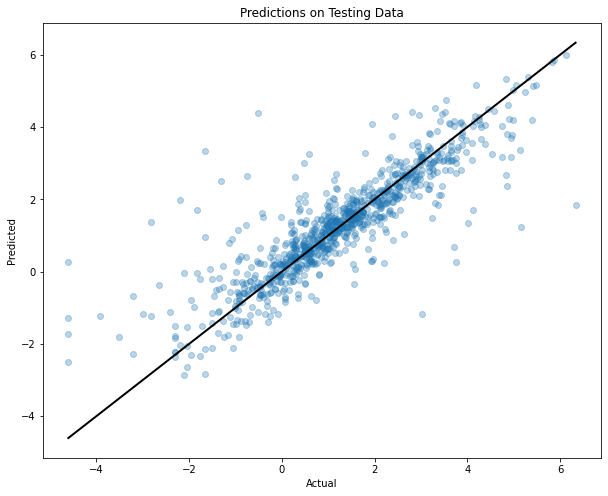

0.7514401545324658

In [34]:
# your code here
from sklearn.metrics import r2_score
forest = RandomForestRegressor(random_state = 42)

forest.fit(X_train_prepared, y_train)

y_pred = forest.predict(X_test_prepared)

test_r2 = r2_score(y_test, y_pred)

plt.figure(figsize = (10, 8))
plt.scatter(y_test, y_pred, alpha = 0.3)
plt.plot([y_test.min(),y_test.max()],[y_test.min(), y_test.max()],'-k',linewidth = 2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions on Testing Data')
plt.show()

test_r2

In [38]:
## test whether 2th and 3rd decimal digits of test_r2 are 51
assert np.mod(int(np.floor(test_r2 * 10**3)), 100) == 51


In [ ]:
## test whether test_r2 is correct (hidden tests)
